# Landscape Expansion Index

More details on the wiki - https://github.com/worldbank/GOST_Urban/wiki/Landscape-Expansion-Index

The Landscape Expansion Index measures the nature of urbanization, quantifying the new urban landscape as one of the following three categories. The process works by isolating the areas of new urban footprint in your study area, buffering those by a set amount (300 m) and intersecting the buffer donut with the original urban area. LEI is calculated as the ratio of the area of the buffer to the area of the old built area within the buffer (the threshold for each class is customizeable). 

| Expansion Type | Description | 
| --- | --- |
| Infill | > 80% of the donut is in the old urban area |
| Expansion | > 20% and < 80% of the donut is in the old urban area |
| Leapfrog | < 20% of the donut is in the old urban area |

In [1]:
import os
import sys
import importlib
import rasterio
import rasterio.features

import geopandas as gpd
import pandas as pd
import numpy as np

import GOSTrocks.rasterMisc as rMisc
import GOSTrocks.ghslMisc as ghslMisc
import GOSTurban.LEI as lei
import GOSTrocks.mapMisc as mapMisc
import GOSTrocks.rasterMisc as rMisc

%load_ext autoreload
%autoreload 2

In [2]:
# Define input variables
tutorial_folder = "../../data/tutorial_data"
aoi_file = os.path.join(tutorial_folder, "AOI_GHSL.geojson")
input_ghsl = os.path.join(tutorial_folder, "GHSL.tif")

In [3]:
# This section will extract GHSL data from global data, if you have the GHSL for the AOI extracted
#    define above as input_ghsl
if not os.path.exists(input_ghsl):
    temp_folder = "C:/Temp"
    # clip from global GHSL file
    ghsl_folder = "J:/Data/GLOBAL/GHSL/built"
    ghsl_files = [os.path.join(ghsl_folder, x) for x in os.listdir(ghsl_folder) if x.endswith(".tif")]    
    inA = gpd.read_file(aoi_file)
    
    temp_ghsl_files = []
    for ghsl_file in ghsl_files:
        temp_file = os.path.join(temp_folder, os.path.basename(ghsl_file))
        temp_ghsl_files.append(temp_file)
        if not os.path.exists(temp_file):
            rMisc.clipRaster(rasterio.open(ghsl_file), inA, temp_file)
            
    ghsl_res, ghsl_profile = ghslMisc.combine_ghsl_annual(temp_ghsl_files)
    with rasterio.open(input_ghsl, 'w', **ghsl_profile) as outR:
        outR.write_band(1, ghsl_res)

# GHSL data

This tutorial relies on the Global Human Settlement Layer (GHSL) produced by the European Commission ([download the data here])(https://ghsl.jrc.ec.europa.eu/download.php).

The current release of the data provides individual layers ber annum of fractional area built per 1 hectare cell. For the LEI examples, we need binary data of existing built and new built. We leverage a function from the [GOSTrocks library](https://github.com/worldbank/GOSTrocks) to combine these multiple yearly layers into a single geotiff with each pixel labelled with the year it was built. 

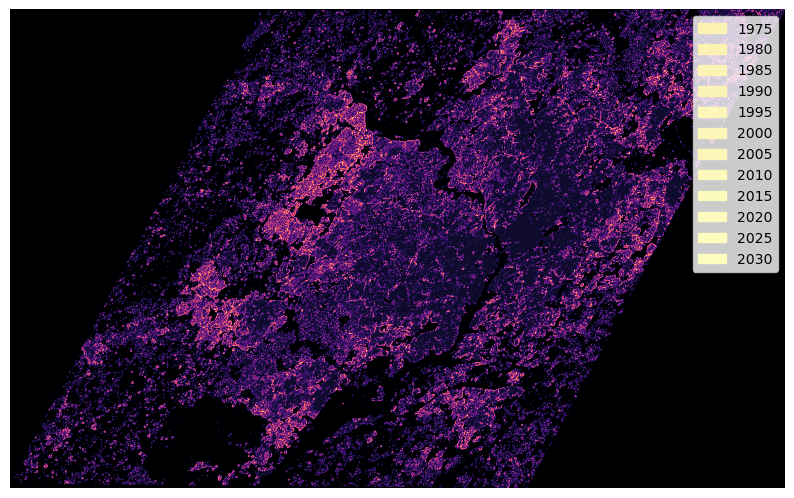

In [4]:
ghsl_r = rasterio.open(input_ghsl)
ghsl_d = ghsl_r.read()
ghsl_d[ghsl_d == ghsl_r.meta['nodata']] = 0

thresh = list(range(1975, 2031, 5))
with rMisc.create_rasterio_inmemory(ghsl_r.profile, ghsl_d) as temp_ghsl:
    mapMisc.static_map_raster(temp_ghsl, thresh=thresh)

## Calculate LEI between 1990 and 2000

In [ ]:
# This calculates the change from 1990 and 2000
lei_raw = lei.calculate_LEI(input_ghsl, old_list=list(range(1975,1991,5)), new_list=list(range(1995,2001,5)))
lei_90_00 = gpd.GeoDataFrame(pd.DataFrame(lei_raw, columns=["geometry", "old", "total"]), geometry='geometry', crs=ghsl_r.crs)
lei_90_00["LEI"] = lei_90_00["old"] / lei_90_00["total"]

lei_90_00.head()

In [ ]:
#Map LEI results
leap_val=0.30
exp_val=0.70
lei_90_00['area'] = lei_90_00['geometry'].apply(lambda x: x.area)
def calculate_LEI(val, leap_val, exp_val):
    if val <= leap_val:
        return 3
    elif val < exp_val:
        return 2
    else:
        return 1
lei_90_00["class"] = lei_90_00["LEI"].apply(lambda x: calculate_LEI(x, leap_val, exp_val))
mapMisc.static_map_vector(lei_90_00, "class", edgecolor='match', colormap="Dark2")#, basemap=ctx.providers.CartoDB.Voyager)

In [ ]:
# Calculate summaries of lei as area (km2) in each class
lei.summarize_LEI(lei_90_00, leap_val=0.05, exp_val=0.75) / 1000000

## Calculate LEI between 2000 and 2030

In [ ]:
# This calculates the change from 2000 and 2014
lei_raw = lei.calculate_LEI(input_ghsl, old_list=list(range(1975,2011,5)), new_list=list(range(2015,2030,5)))
lei_00_14 = pd.DataFrame(lei_raw, columns=["geometry", "old", "total"])
lei_00_14["LEI"] = lei_00_14["old"] / lei_00_14["total"]
lei_00_14.head()

In [ ]:
#Map LEI results
leap_val=0.30
exp_val=0.70
lei_90_00['area'] = lei_90_00['geometry'].apply(lambda x: x.area)
def calculate_LEI(val, leap_val, exp_val):
    if val <= leap_val:
        return 3
    elif val < exp_val:
        return 2
    else:
        return 1
lei_90_00["class"] = lei_90_00["LEI"].apply(lambda x: calculate_LEI(x, leap_val, exp_val))
mapMisc.static_map_vector(lei_90_00, "class", edgecolor='match', colormap="Dark2")#, basemap=ctx.providers.CartoDB.Voyager)

In [ ]:
# Calculate summaries of lei
lei.summarize_LEI(lei_00_14, leap_val=0.05, exp_val=0.75) / 1000000

In [ ]:
# write raw LEI results to file
lei_90_00.to_csv(os.path.join(input_folder, "GHSL_LEI_90_00.csv"))
lei_00_14.to_csv(os.path.join(input_folder, "GHSL_LEI_00_14.csv"))